In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import warnings 
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_csv("/Users/andrewabello/Desktop/Spice_HW.csv")

# Group by Year and sum all consumption
df = df.groupby("Year")["Consumption"].sum().reset_index()

df.columns = ["Year", "Total_Consumption"] # Rename columns (optional, cleaner)

df["Year"] = pd.to_datetime(df["Year"], format="%Y")
df.set_index("Year", inplace=True)

df.head(20)


,Total_Consumption
Year,
1993-01-01,17664954.12
1994-01-01,18923207.56
1995-01-01,20732463.31
1996-01-01,24445784.29
1997-01-01,25940225.89


### Plot the series

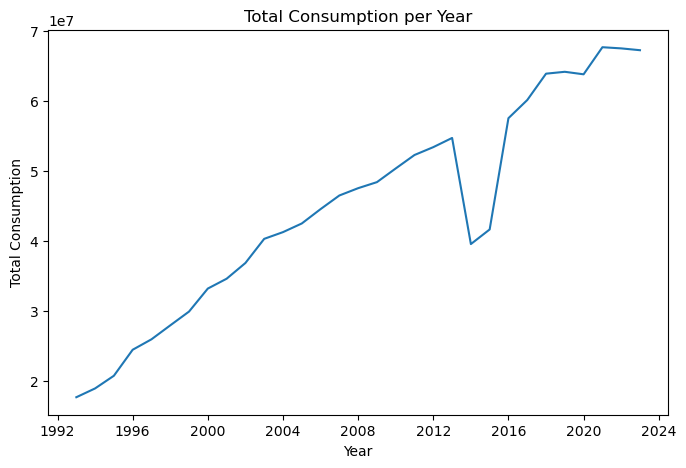

In [32]:
plt.figure(figsize=(8,5))
plt.plot(df.index, df["Total_Consumption"])
plt.title("Total Consumption per Year")
plt.xlabel("Year")
plt.ylabel("Total Consumption")
plt.show()

### decomposition analysis

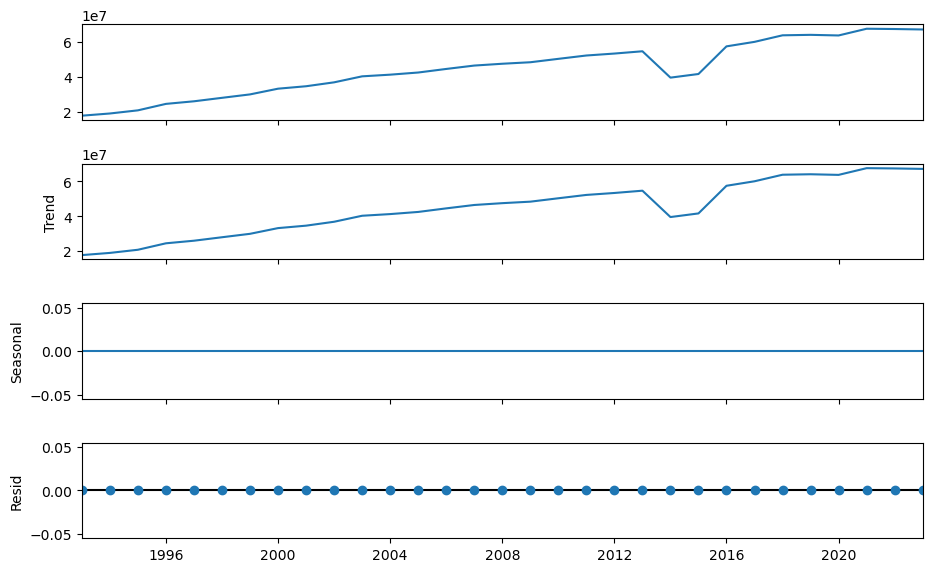

In [34]:
decomposition = seasonal_decompose(df,  model="Additive")
fig = decomposition.plot()
fig.set_size_inches(10,6)
plt.show()

# Yearly data, One observation per year, So there is no repeated seasonal cycle inside a year. (No seasonality)
# based on this we use Holts method (Double-Exponential Smoothing)

### Train- Test Split

In [75]:
train = df.iloc[:-3]["Total_Consumption"]
test = df.iloc[-3:]["Total_Consumption"]

## Baseline Models (Naive, Historic Average and Window Average)

In [79]:
# Naive
naive_forecast = np.repeat(train.iloc[-1], 3)
naive_forecast = pd.Series(naive_forecast, index=test.index)

In [81]:
# Historical Average
hist_avg_forecast = np.repeat(train.mean(), 3)
hist_avg_forecast = pd.Series(hist_avg_forecast, index=test.index)

In [83]:
# Window Average
window_avg_forecast = np.repeat(train.iloc[-6:].mean(), 3)
window_avg_forecast = pd.Series(window_avg_forecast, index=test.index)

### Evaluation Metrics for Baseline models

In [86]:
def evaluate(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return round(mae,2), round(rmse,2)

print("Naive:", evaluate(test, naive_forecast))
print("Historical Avg:", evaluate(test, hist_avg_forecast))
print("Window Avg:", evaluate(test, window_avg_forecast))

Naive: (3671977.75, 3676161.58)
Historical Avg: (25235282.01, 25235891.13)
Window Avg: (8948387.29, 8950104.94)


## Holts Method (In-Sample)

In [88]:
model = ExponentialSmoothing(train, 
                             trend = "add", #Additive trend
                            seasonal= None) # we have no seasonality
fit = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


### Forecast Exactly 3 Periods

In [90]:
forecast = fit.forecast(len(test))

### Plot Forecast and Test

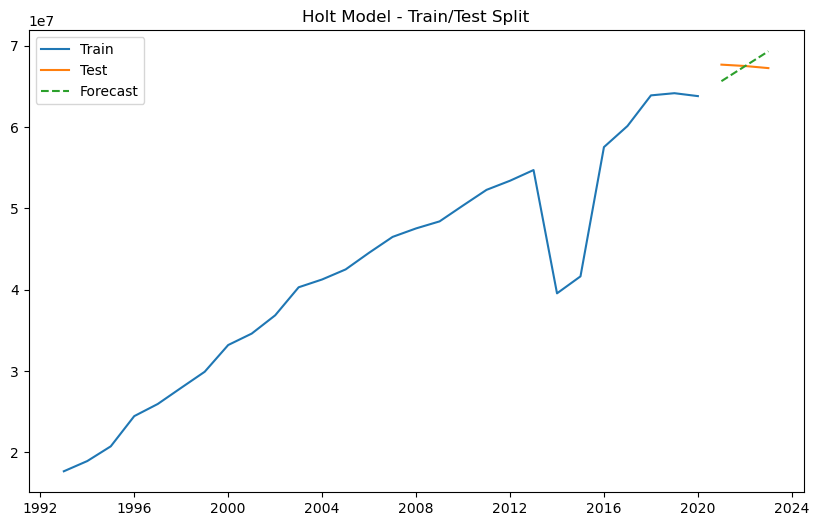

In [96]:
plt.figure(figsize=(10,6))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--")

plt.legend()
plt.title("Holt Model - Train/Test Split")
plt.show()

### Evaluation Metrics For Holts Method

In [98]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1376452.4490897555
RMSE: 1674483.4824547993


## ARIMA (In-Sample)

In [111]:
df_arima = df.copy()

### New Train Test split with log values

In [114]:
train_log = np.log(train)
test_log = np.log(test)

### check for stationarity

In [138]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey-Fuller Test Results: ")
    print("ADF statistic:", result[0])
    print("P-Value", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    return result[1] < 0.05

is_stationary = check_stationarity(train_log)
print(f"\nTime series is {"stationary" if is_stationary else "non-stationary"}")

Augmented Dickey-Fuller Test Results: 
ADF statistic: -2.6919338190929523
P-Value 0.07544450161309484
Critical Values:
	1%: -3.7883858816542486
	5%: -3.013097747543462
	10%: -2.6463967573696143

Time series is non-stationary


### AutoArima

In [144]:
arima_model = auto_arima(
    train_log,
    seasonal=False,
    trace=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-46.243, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44.421, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-44.775, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-42.253, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.974 seconds


### Forecast 3 Steps Ahead

In [147]:
forecast_log = arima_model.predict(n_periods=3)

### Convert back to original scale

In [151]:
forecast_arima = np.exp(forecast_log)
forecast_arima = pd.Series(forecast_arima, index=test.index)

### Plot Forecast and Test

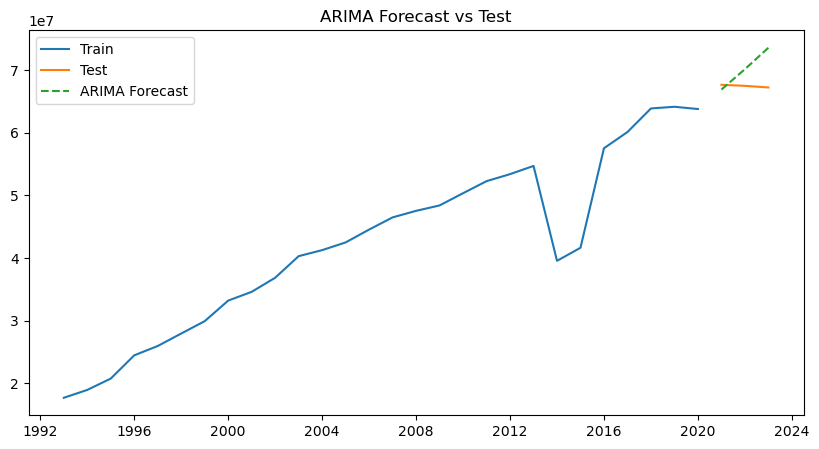

In [160]:
plt.figure(figsize=(10,5))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(forecast_arima.index, forecast_arima, label="ARIMA Forecast", linestyle="--")

plt.legend()
plt.title("ARIMA Forecast vs Test")
plt.show()

### Evaluation Metrics for Auto Arima

In [157]:
mae = mean_absolute_error(test, forecast_arima) #test: original units
rmse = np.sqrt(mean_squared_error(test, forecast_arima))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 3255036.8325775936
RMSE: 3994626.728904483


## Holts Method (Out-of-Sample)

### Re-Fit Holts Method to all data

In [165]:
holt_final = ExponentialSmoothing(
    df["Total_Consumption"],
    trend="add",
    seasonal=None
).fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Forecast Next Year (1 step ahead)

In [173]:
forecast_next_year = holt_final.forecast(1)

print("Forecast for next year:")
print(forecast_next_year)

# next year = 68,922,690

Forecast for next year:
2024-01-01    6.892269e+07
Freq: YS-JAN, dtype: float64


### Plot Holts Method Forecast for Next Year

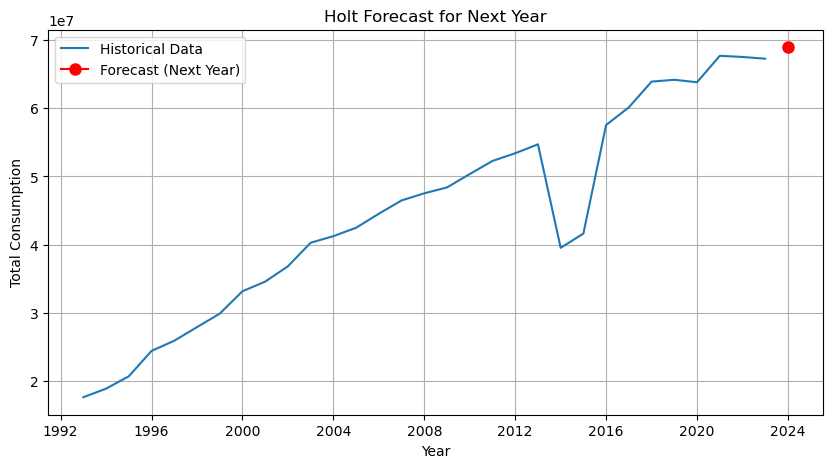

In [175]:
plt.figure(figsize=(10,5))

# Historical data
plt.plot(df.index, df["Total_Consumption"], label="Historical Data")

# Forecast point
plt.plot(forecast_next_year.index,
         forecast_next_year.values,
         marker='o',
         markersize=8,
         color='red',
         label="Forecast (Next Year)")

plt.title("Holt Forecast for Next Year")
plt.xlabel("Year")
plt.ylabel("Total Consumption")
plt.legend()
plt.grid(True)

plt.show()


## Conclusion
- The total yearly consumption series shows a strong upward trend with no visible seasonality.
- Baseline models (Naive, Historical Average, Window Average) were used as simple benchmarks for comparison.
- Among baseline models, the Historical Average performed better than Naive and Window Average, but errors remained relatively high.
- Holt’s Double Exponential Smoothing (trend-only model) achieved the lowest MAE and RMSE, outperforming all other models.
- ARIMA was tested after log transformation and differencing, but it did not outperform Holt’s method.
- The superior performance of Holt’s model suggests the data follows a mostly deterministic linear trend rather than a complex stochastic process.
- Given the small sample size and absence of seasonality, Holt’s method is the most appropriate forecasting model for this dataset.